In [27]:
import string
import re

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import nltk

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, load_model
from keras import metrics
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, TerminateOnNaN

from nltk.translate.bleu_score import corpus_bleu

from datasets import load_dataset

import matplotlib.pyplot as plt

# Load the dataset
raw_datasets = load_dataset("cfilt/iitb-english-hindi")

In [2]:
def preprocess(text):
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    text = text.lower()
    text = re.sub(r'\d','',text)
    text = re.sub(r'\s+',' ',text)  #Remove extra spaces
    text = text.strip()
    return text

In [3]:
data = raw_datasets["train"]["translation"]
    
eng_sen = []
hin_sen = []

# rows = [{"en": item["en"], "hi": item["hi"]} for item in data]
for item in data:
    eng_sen.append(item['en'])
    hin_sen.append(item['hi'])
    
eng_sen = [preprocess(en) for en in eng_sen]
hin_sen = [' ' + re.sub('[a-zA-Z]', '', preprocess(hi)) + ' ' for hi in hin_sen]

# Remove duplicate sentences
english_unique = set()
english_sentences_temp = []
hindi_sentences_temp = []
l = len(eng_sen)
for i in range(l):
    if eng_sen[i] not in english_unique:
        english_unique.add(eng_sen[i])
        english_sentences_temp.append(eng_sen[i])
        hindi_sentences_temp.append(hin_sen[i])

eng_sen = english_sentences_temp
hin_sen = hindi_sentences_temp

In [4]:
print(len(eng_sen), len(hin_sen))
print()
eng_sen[:3], hin_sen[:3]

1044136 1044136



(['give your application an accessibility workout',
  'accerciser accessibility explorer',
  'the default plugin layout for the bottom panel'],
 [' अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें ',
  ' एक्सेर्साइसर पहुंचनीयता अन्वेषक ',
  ' निचले पटल के लिए डिफोल्ट प्लगइन खाका '])

In [33]:
vocab_size = 100000
total_sentences = 50000
maxlen = 10
epochs = 30
validation_split = 0.05

In [34]:
en_data = []
hi_data = []

cnt = 0

for (en, hi) in zip(eng_sen, hin_sen):
    l = min(len(en.split()), len(hi.split()))
    if l <= maxlen:
        en_data.append(en)
        hi_data.append(hi)
        cnt += 1
    if cnt == total_sentences:
        break

hi_data = ['<START> ' + hi + ' <END>' for hi in hi_data]

In [35]:
en_tokenizer = Tokenizer(filters='', oov_token='', lower=False)
en_tokenizer.fit_on_texts(en_data)
en_sequences = en_tokenizer.texts_to_sequences(en_data)

hi_tokenizer = Tokenizer(filters='', oov_token='', lower=False)
hi_tokenizer.fit_on_texts(hi_data)
hi_sequences = hi_tokenizer.texts_to_sequences(hi_data)

english_vocab_size = len(en_tokenizer.word_index) + 1
hindi_vocab_size = len(hi_tokenizer.word_index) + 1
print("English Vocab Size: ", english_vocab_size)
print("Hindi Vocab Size: ", hindi_vocab_size)

English Vocab Size:  19694
Hindi Vocab Size:  19688


In [36]:
encoder_inputs = pad_sequences(en_sequences, maxlen=maxlen, padding='post')

In [37]:
# Prepare decoder data
decoder_inputs = []
decoder_outputs = []

for hi in hi_sequences:
    decoder_inputs.append(hi[:-1])
    decoder_outputs.append(hi[1:])

decoder_inputs = pad_sequences(decoder_inputs, maxlen=maxlen, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=maxlen, padding='post')

In [38]:
# Training and Testing split
# 95%, 5%
split = int(0.95 * total_sentences)

X_train = [encoder_inputs[:split], decoder_inputs[:split]]
y_train = decoder_outputs[:split]

# Test data to evaluate our NMT model using BLEU score
X_test = en_data[:split]
y_test = hi_data[:split]

print(X_train[0].shape, X_train[1].shape, y_train.shape)

(47500, 10) (47500, 10) (47500, 10)


In [39]:
# Define LSTM model
d_model = 256

# Encoder
inputs = Input(shape=(None,))
x = Embedding(english_vocab_size, d_model, mask_zero=True)(inputs)
_, state_h, state_c = LSTM(d_model, activation='relu', return_state=True)(x)

# Decoder
targets = Input(shape=(None,))
embedding_layer = Embedding(hindi_vocab_size, d_model, mask_zero=True)
x = embedding_layer(targets)
decoder_lstm = LSTM(d_model, activation='relu', return_sequences=True, return_state=True)
x,_,_ = decoder_lstm(x, initial_state=[state_h, state_c])

dense = Dense(hindi_vocab_size, activation='softmax')
x = dense(x)

model = Model(inputs=[inputs, targets], outputs=x)
model.summary()

loss = SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            5041664   ['input_5[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, None, 256)            5040128   ['input_6[0][0]']             
                                                                                            

In [12]:
# Save model after each epoch
save_model_callback = ModelCheckpoint(
    filepath='/home/bindra.p/cs6140/nmt-models/en-hi-1',
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[save_model_callback, TerminateOnNaN()])

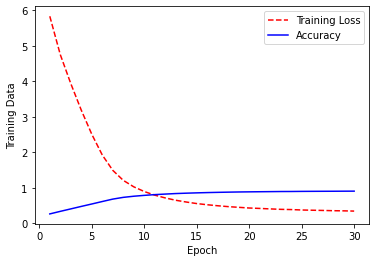

In [14]:
# model.history.history.keys()
loss = model.history.history['loss']
acc = model.history.history['accuracy']
epoch_count = range(1, len(loss) + 1)

# Visualize graph
plt.plot(epoch_count, loss, 'r--')
plt.plot(epoch_count, acc, 'b-')
plt.legend(['Training Loss', 'Accuracy'])
plt.xlabel('Epoch')  
plt.ylabel('Training Data')
plt.show()

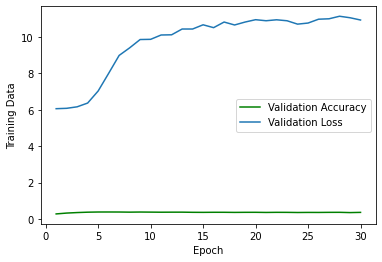

In [15]:
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']

# Visualize graph
plt.plot(epoch_count, val_acc, 'g-')
plt.plot(epoch_count, val_loss)
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Data')
plt.show()

In [14]:
saved_model = load_model('/home/bindra.p/cs6140/nmt-models/en-hi-4')

In [41]:
# Retrieve previously saved stuff
saved_model = load_model('/home/bindra.p/cs6140/nmt-models/en-hi-4')

saved_model.summary()
inputs = saved_model.get_layer('input_9').output
_, state_h, state_c = saved_model.get_layer('lstm_4').output
targets = saved_model.get_layer('input_10').output
embedding_layer = saved_model.get_layer('embedding_5')
decoder_lstm = saved_model.get_layer('lstm_5')
dense1 = saved_model.get_layer('dense_2')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, None, 256)            5041664   ['input_9[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, None, 256)            5040128   ['input_10[0][0]']            
                                                                                            

In [42]:
#Inference Model

#Encoder
encoder = Model(inputs, [state_h, state_c])

#Decoder
decoder_input_h = Input(shape=(d_model,))
decoder_input_c = Input(shape=(d_model,))
x = embedding_layer(targets)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = dense1(x)
decoder = Model([targets] + [decoder_input_h, decoder_input_c], 
                                [x] + [decoder_output_h, decoder_output_c])

In [43]:
def predict_sentence(text):
    input_seq = en_tokenizer.texts_to_sequences([text])

    next_h, next_c = encoder.predict(input_seq)

    curr_token = np.zeros((1, 1))
    curr_token[0, 0] = hi_tokenizer.word_index['<START>']

    pred_sentence = ''

    for i in range(maxlen):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c])
        next_token = np.argmax(output[0, 0, :])
        next_word = hi_tokenizer.index_word[next_token]
        if next_word == '<END>':
            break
        else:
            pred_sentence += ' ' + next_word
            curr_token[0, 0] = next_token

    return pred_sentence

In [44]:
#Testing and Analysis

candidates = []
references = []

ctr = 20 
i = 0

while ctr > 0:
    l = len(X_test[i].split())
    if l <= maxlen:
        print("i =", i)
        pred_sentence = predict_sentence(X_test[i])
        
        candidates.append(pred_sentence.split())
        print("Input: ", X_test[i])
        print("Prediction: ", pred_sentence)
        print("Dataset Reference: ", ' '.join(y_test[i].split()[1:-1]), "\n")

        references.append([(y_test[i].split()[1:-1])])

        ctr -= 1
    i += 1

print("\nBLEU score =", corpus_bleu(references, candidates))

i = 0
1/1 [==============================] - 0s 28ms/step
Input:  give your application an accessibility workout
Prediction:   अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
Dataset Reference:  अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें 

i = 1
1/1 [==============================] - 0s 27ms/step
Input:  accerciser accessibility explorer
Prediction:   एक्सेर्साइसर पहुंचनीयता अन्वेषक
Dataset Reference:  एक्सेर्साइसर पहुंचनीयता अन्वेषक 

i = 2
1/1 [==============================] - 0s 29ms/step
Input:  the default plugin layout for the bottom panel
Prediction:   निचले पटल के लिए डिफोल्ट प्लगइन खाका
Dataset Reference:  निचले पटल के लिए डिफोल्ट प्लगइन खाका 

i = 3
1/1 [==============================] - 0s 19ms/step
Input:  the default plugin layout for the top panel
Prediction:   ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
Dataset Reference:  ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका 

i = 4
1/1 [==============================] - 0s 25ms/step
Input:  a list of plugins that are disabled by default
P